**Import Libraries**

In [13]:
# Import libraries
import os
import pandas as pd
import requests
import zipfile
import io
import inspect
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor


# Define target feature
target_feature = 'Voter_Percentage'

**Download and Unpack Source Data File**

In [14]:
# Define the URL of the ZIP file
url = 'https://github.com/lior-emuna/voting-predictions/raw/main/Resources.zip'

# Download the ZIP file
response = requests.get(url)

# Create a directory to unpack the contents
unpack_dir = '/content'
os.makedirs(unpack_dir, exist_ok=True)

# Unpack the ZIP file
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    z.extractall(unpack_dir)

Utility Functions

In [15]:
# Utility functions

def remove_quotes(x):
    return x.replace("'", "").replace('"', '')

**Data Transformation and Handling Functions**

In [16]:
def trans_semel(semel_yeshuv):
    while semel_yeshuv < 1000:
        semel_yeshuv = semel_yeshuv * 10
    semel_yeshuv = semel_yeshuv * 10000
    return semel_yeshuv

def handle_stat_columns(stat_file):
    kalpi = stat_file.columns[stat_file.columns.str.contains('קלפי')][0]
    stat = stat_file.columns[stat_file.columns.str.contains('סטטיסטי')][0]
    semel = stat_file.columns[stat_file.columns.str.contains('סמל')][0]
    shem = stat_file.columns[stat_file.columns.str.contains('שם')][0]
    stat_file.rename(columns={semel: 'סמל ישוב',
                              shem: 'שם ישוב',
                              kalpi: 'קלפי',
                              stat: 'CODE_OF_STATISTICAL_AREA'},
                     inplace=True)
    cols_to_keep = ['סמל ישוב', 'קלפי', 'CODE_OF_STATISTICAL_AREA']
    stat_file = stat_file.filter(items=cols_to_keep)
    return stat_file

def handle_res_columns(res_file):
    res_file.columns = res_file.columns.map(remove_quotes)
    columns_to_drop = ['סמל ועדה', 'ברזל', 'שופט', 'ריכוז']
    res_file.drop(columns=columns_to_drop, inplace=True, errors='ignore')
    try:
        voters = res_file.columns[res_file.columns.str.contains('ב.*ח.*ר', regex=True)][0]
    except IndexError:
        voters = res_file.columns[res_file.columns.str.contains('בזב', regex=True)][0]
    kalpi = res_file.columns[res_file.columns.str.contains('קלפי')][0]
    res_file.rename(columns={voters: 'בזב', kalpi: 'קלפי'}, inplace=True)

    na_columns = res_file.filter(like='Unnamed').columns.tolist()
    if len(na_columns) > 0:
        res_file = res_file.drop(columns=na_columns)

    res_file = res_file.dropna()
    res_file.loc[:, 'קלפי'] = res_file['קלפי'].astype(int)

    column_types = res_file.dtypes
    datetime_columns = column_types[column_types == 'datetime64[ns]'].index
    if len(datetime_columns) > 0:
        res_file = res_file.drop(columns=datetime_columns)
    return res_file

**Data Aggregation and Merging Functions**

In [17]:
def get_kalpi_results(resFile, statFile):
    fname, extention = os.path.splitext(os.path.basename(resFile))
    if extention == '.csv':
        try:
            with open(resFile, 'rb') as f:
                kalpi_results = pd.read_csv(f, encoding='iso-8859-8')
        except UnicodeDecodeError:
            kalpi_results = pd.read_csv(resFile, encoding='utf-8')
    else:
        kalpi_results = pd.read_excel(resFile)
    kalpi_results = handle_res_columns(kalpi_results)

    kalpiStat = pd.read_excel(statFile)
    kalpiStat = handle_stat_columns(kalpiStat)

    kalpi_results_stat = pd.merge(kalpi_results, kalpiStat, on=['סמל ישוב', 'קלפי'], how='left')
    kalpi_results_stat['CODE_OF_STATISTICAL_AREA'] = kalpi_results_stat['CODE_OF_STATISTICAL_AREA'].fillna(-1)
    kalpi_results_stat.drop(columns=['קלפי'], inplace=True)

    groupby = ['סמל ישוב', 'CODE_OF_STATISTICAL_AREA']
    agg_funcs = {}
    for col in kalpi_results_stat.columns:
        if 'שם ישוב' in col:
            agg_funcs[col] = 'first'
        elif col not in ['סמל ישוב', 'CODE_OF_STATISTICAL_AREA']:
            agg_funcs[col] = 'sum'
    kalpi_results_stat_agg = kalpi_results_stat.groupby(groupby).agg(agg_funcs).reset_index()

    kalpi_results_stat_agg['source'] = fname
    kalpi_results_stat_agg_merged = include_cbs_data(kalpi_results_stat_agg)
    columns_to_drop = ['שם ישוב', 'שם_יישוב', 'סמל ישוב']
    kalpi_results_stat_agg_merged.columns = kalpi_results_stat_agg_merged.columns.str.strip()
    kalpi_results_stat_agg_merged.drop(columns=columns_to_drop, inplace=True)
    return kalpi_results_stat_agg_merged

def include_cbs_data(voting_result):
    if voting_result['source'][0].lstrip('results_') == '20':
        cbs = pd.read_excel('/content/Resources/cbs-transformed/socio_economic_scale_t1+t7+t12_2017.xlsx')
    else:
        cbs = pd.read_excel('/content/Resources/cbs-transformed/socio_economic_scale_t1+t7+t12_2019.xlsx')
    merged_result = pd.merge(voting_result, cbs,
                             left_on=['סמל ישוב', 'CODE_OF_STATISTICAL_AREA'],
                             right_on=['CODE_OF_LOCALITY', 'CODE_OF_STATISTICAL_AREA'],
                             how='inner')
    return merged_result


**Functions for Handling Voting Data**

In [18]:
def get_all_vote_data(save=True):
    kalpi_votes = "/content/Resources/kalpi_votes/"
    kalpi_stat = "/content/Resources/kalpi_stat/"
    all_files = []
    for kalpi_votes_file, kalpi_stat_file in zip(sorted(os.listdir(kalpi_votes)), sorted(os.listdir(kalpi_stat))):
        kalpi_votes_path = os.path.join(kalpi_votes, kalpi_votes_file)
        kalpi_stat_path = os.path.join(kalpi_stat, kalpi_stat_file)
        res_file = get_kalpi_results(kalpi_votes_path, kalpi_stat_path)
        all_files.append(res_file)
        if save:
            fname = res_file['source'][0]
            res_file.to_excel(f'{fname}.xlsx', index=False)
    return all_files

def get_single_vote_data(vote, stat, save=True):
    kalpi_votes = f'/content/Resources/kalpi_votes/{vote}'
    kalpi_stat = f'/content/Resources/kalpi_stat/{stat}'
    res_file = get_kalpi_results(kalpi_votes, kalpi_stat)
    return res_file

def calculate_voting_percentage(data):
  data['Voting precantage'] = data['מצביעים'] / data['בזב']
  data['Voting precantage'] = np.round(data['Voting precantage'], 2)
  return data


**Functions for Handling Religion Data**

In [19]:
def split_and_merge_religion_data(data):
    # Split the religion table
    religion_total = religion[religion['אזור סטטיסטי'] == 'סה"כ']
    religion_specific = religion[religion['אזור סטטיסטי'] != 'סה"כ']

    # Perform a normal merge for specific areas
    merged_specific = pd.merge(
        data,
        religion_specific,
        left_on=['CODE_OF_LOCALITY', 'CODE_OF_STATISTICAL_AREA'],
        right_on=['סמל יישוב', 'אזור סטטיסטי']
    )

    # Merge with 'סה"כ' rows
    merged_total = pd.merge(
        data,
        religion_total.drop(columns=['אזור סטטיסטי']),  # drop the column as it is not needed in merge
        left_on=['CODE_OF_LOCALITY'],
        right_on=['סמל יישוב']
    )

    # Combine the results
    final_merged = pd.concat([merged_specific, merged_total], ignore_index=True)

    return final_merged

def add_max_column_and_encode(final_merged):
    # Define the function to get the max column
    def get_max_column(row):
        max_value = None
        max_column = None
        for column in row.index:
            if max_value is None or row[column] > max_value:
                max_value = row[column]
                max_column = column
        return max_column

    # Create a new column called "Max Column" in the DataFrame
    columns_to_check = ['יהודים%', 'מוסלמים%', 'נוצרים ערבים%', 'נוצרים לא-ערבים%', 'דרוזים%', 'ללא סיווג דת%']
    final_merged['Max Column'] = final_merged[columns_to_check].apply(get_max_column, axis=1)

    # Perform one-hot encoding on "Max Column"
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    max_column_data = final_merged["Max Column"].values.reshape(-1, 1)
    encoded_data = pd.DataFrame(ohe.fit_transform(max_column_data), columns=ohe.get_feature_names_out(["Max Column"]))

    # Join the encoded data with the original DataFrame
    final_merged = pd.concat([final_merged, encoded_data], axis=1)

    return final_merged


**Functions for Handling Missing Values**

In [20]:
def handle_missing_values(dataset):
    columns_with_mode = [col for col in dataset.columns if 'RANK' in col]
    columns_with_mode += [col for col in dataset.columns if 'STANDARDIZED' in col]
    columns_with_mode += [col for col in dataset.columns if 'VALUE' in col]
    for i in range(1, 11):
        selected = dataset[dataset['_SOCIO_ECONOMIC_INDEX_-CLUSTER'] == i]
        for col in columns_with_mode:
            selected.loc[:, col] = pd.to_numeric(selected[col], errors='coerce')
            mean_col = selected[col].mean()
            selected.loc[:, col] = selected[col].fillna(mean_col)

        dataset.update(selected)
    return dataset

def get_train_and_test(train, test, save=True):
    kalpi_votes = "/content/Resources/kalpi_votes/"
    kalpi_stat = "/content/Resources/kalpi_stat/"
    for kalpi_votes_file, kalpi_stat_file in zip(sorted(os.listdir(kalpi_votes)), sorted(os.listdir(kalpi_stat))):
        kalpi_votes_path = os.path.join(kalpi_votes, kalpi_votes_file)
        kalpi_stat_path = os.path.join(kalpi_stat, kalpi_stat_file)
        res_file = get_kalpi_results(kalpi_votes_path, kalpi_stat_path)
        if res_file['source'][0].lstrip('results_') == '25':
            test = res_file
        else:
            train = pd.concat([train, res_file], ignore_index=True, join='outer')

    train = handle_missing_values(train)
    test = handle_missing_values(test)

    train = add_max_column_and_encode(split_and_merge_religion_data(train))
    test = add_max_column_and_encode(split_and_merge_religion_data(test))

    train = calculate_voting_percentage(train)
    test = calculate_voting_percentage(test)

    if save:
        train.to_excel('train.xlsx', index=False)
        test.to_excel('test.xlsx', index=False)
    return train, test


In [21]:
train, test = get_train_and_test(pd.DataFrame(), pd.DataFrame())

Prepare Train Data

In [22]:
data = train.copy()
all_columns = data.columns
all_columns = [col for col in all_columns if not col.startswith('_SOCIO_ECONOMIC_INDEX')]
value_columns = [col for col in all_columns if col.endswith('-VALUE')]
standardized_value_columns = [col for col in all_columns if col.endswith('-STANDARDIZED_VALUE')]
rank_columns = [col for col in all_columns if col.endswith('-RANK')]
religion_columns = [col for col in all_columns if col.endswith('%')]
religion_oneHot = [col for col in all_columns if col.startswith('Max Column_')]

**Descriptive Statistics**

Correlation with Voting Percentage:
 EMPLOYMENT_AND_BENEFITS-PERCENTAGE_OF_RECIPIENTS_OF_INCOME_SUPPORT_AND_INCOME_SUPPLEMENT_TO_OLD_AGE_PENSION_OF_AGED_20_AND_OVER-RANK                  0.581803
SCHOOLING_AND_EDUCATION-AVERAGE_YEARS_OF_SCHOOLING,_OF_AGED_25_54-STANDARDIZED_VALUE                                                                  0.571850
SCHOOLING_AND_EDUCATION-AVERAGE_YEARS_OF_SCHOOLING,_OF_AGED_25_54-VALUE                                                                               0.564955
SCHOOLING_AND_EDUCATION-AVERAGE_YEARS_OF_SCHOOLING,_OF_AGED_25_54-RANK                                                                                0.564512
EMPLOYMENT_AND_BENEFITS-PERCENTAGE_OF_RECIPIENTS_OF_INCOME_SUPPORT_AND_INCOME_SUPPLEMENT_TO_OLD_AGE_PENSION_OF_AGED_20_AND_OVER-STANDARDIZED_VALUE    0.556906
EMPLOYMENT_AND_BENEFITS-PERCENTAGE_OF_WOMEN_AGED_25_54_WITH_NO_INCOME_FROM_WORK-RANK                                                                  0.515437
EMPLOYMEN

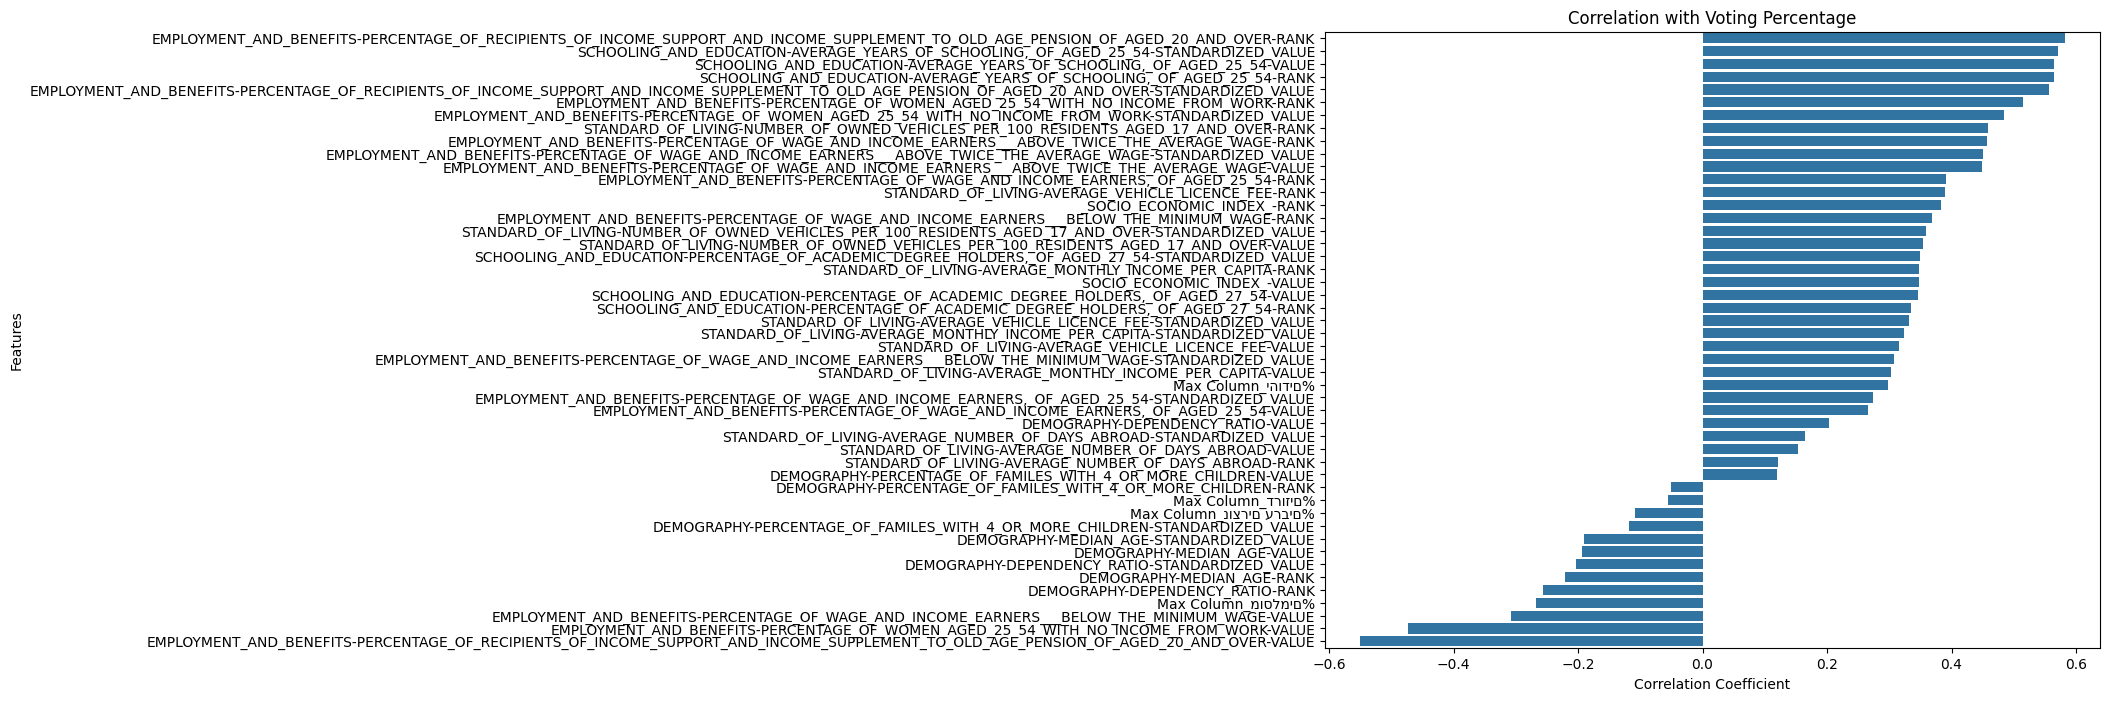

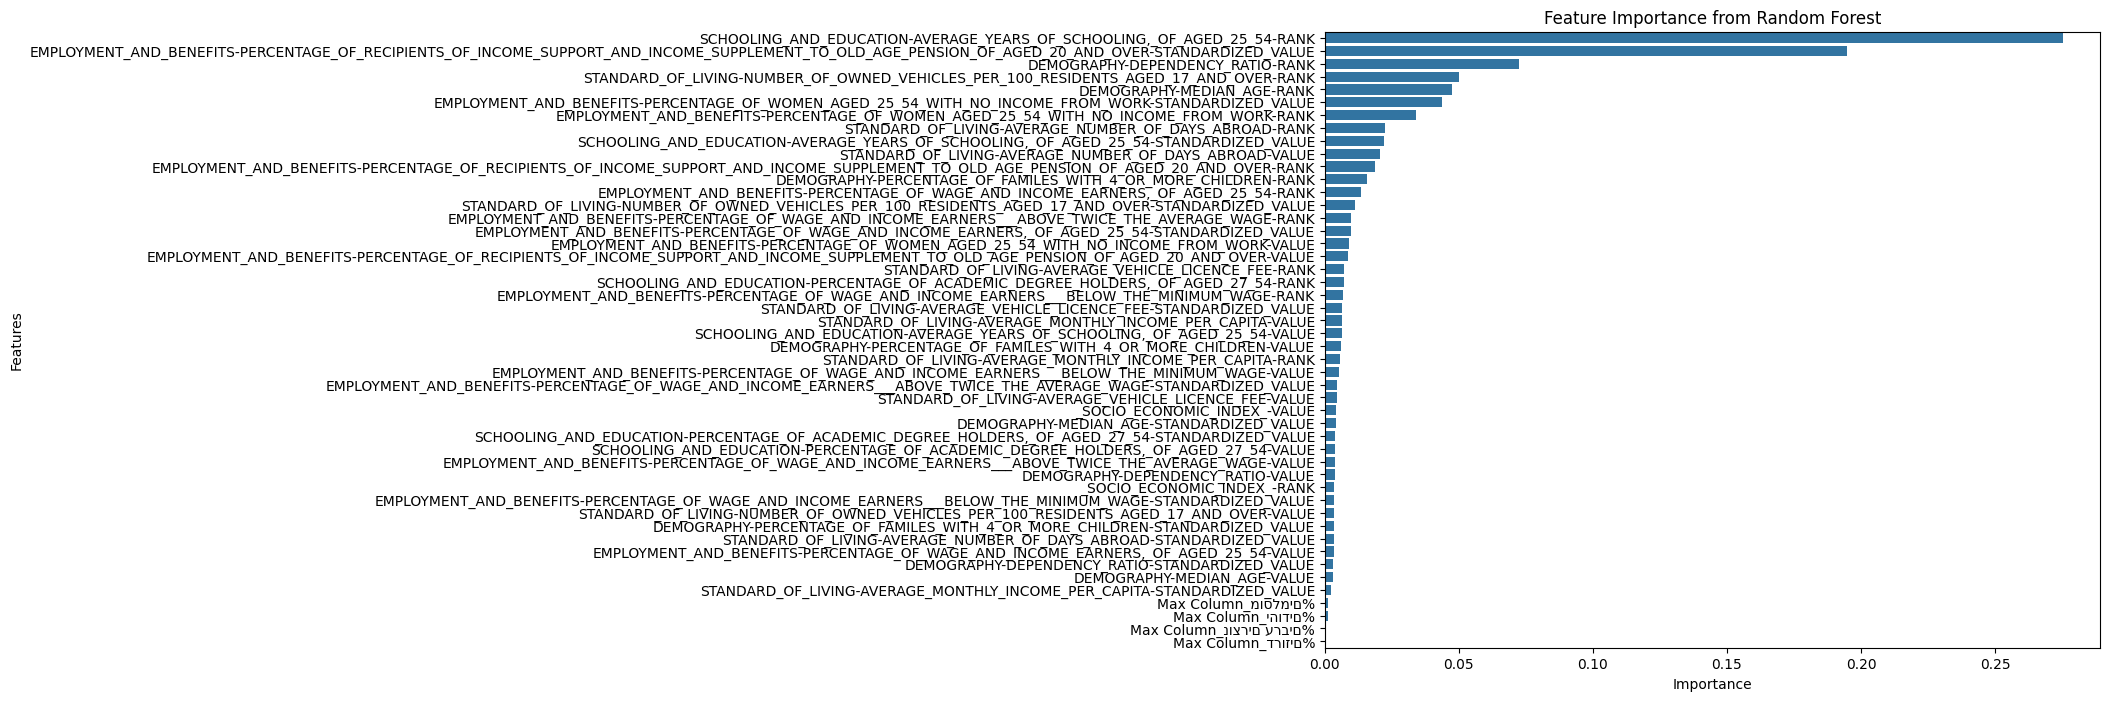

ANOVA F-test scores:
 EMPLOYMENT_AND_BENEFITS-PERCENTAGE_OF_RECIPIENTS_OF_INCOME_SUPPORT_AND_INCOME_SUPPLEMENT_TO_OLD_AGE_PENSION_OF_AGED_20_AND_OVER-RANK                  4021.485487
SCHOOLING_AND_EDUCATION-AVERAGE_YEARS_OF_SCHOOLING,_OF_AGED_25_54-STANDARDIZED_VALUE                                                                  3818.778455
SCHOOLING_AND_EDUCATION-AVERAGE_YEARS_OF_SCHOOLING,_OF_AGED_25_54-VALUE                                                                               3684.336878
SCHOOLING_AND_EDUCATION-AVERAGE_YEARS_OF_SCHOOLING,_OF_AGED_25_54-RANK                                                                                3675.858116
EMPLOYMENT_AND_BENEFITS-PERCENTAGE_OF_RECIPIENTS_OF_INCOME_SUPPORT_AND_INCOME_SUPPLEMENT_TO_OLD_AGE_PENSION_OF_AGED_20_AND_OVER-STANDARDIZED_VALUE    3533.239589
EMPLOYMENT_AND_BENEFITS-PERCENTAGE_OF_RECIPIENTS_OF_INCOME_SUPPORT_AND_INCOME_SUPPLEMENT_TO_OLD_AGE_PENSION_OF_AGED_20_AND_OVER-VALUE                 3410.941684
EMPLOY

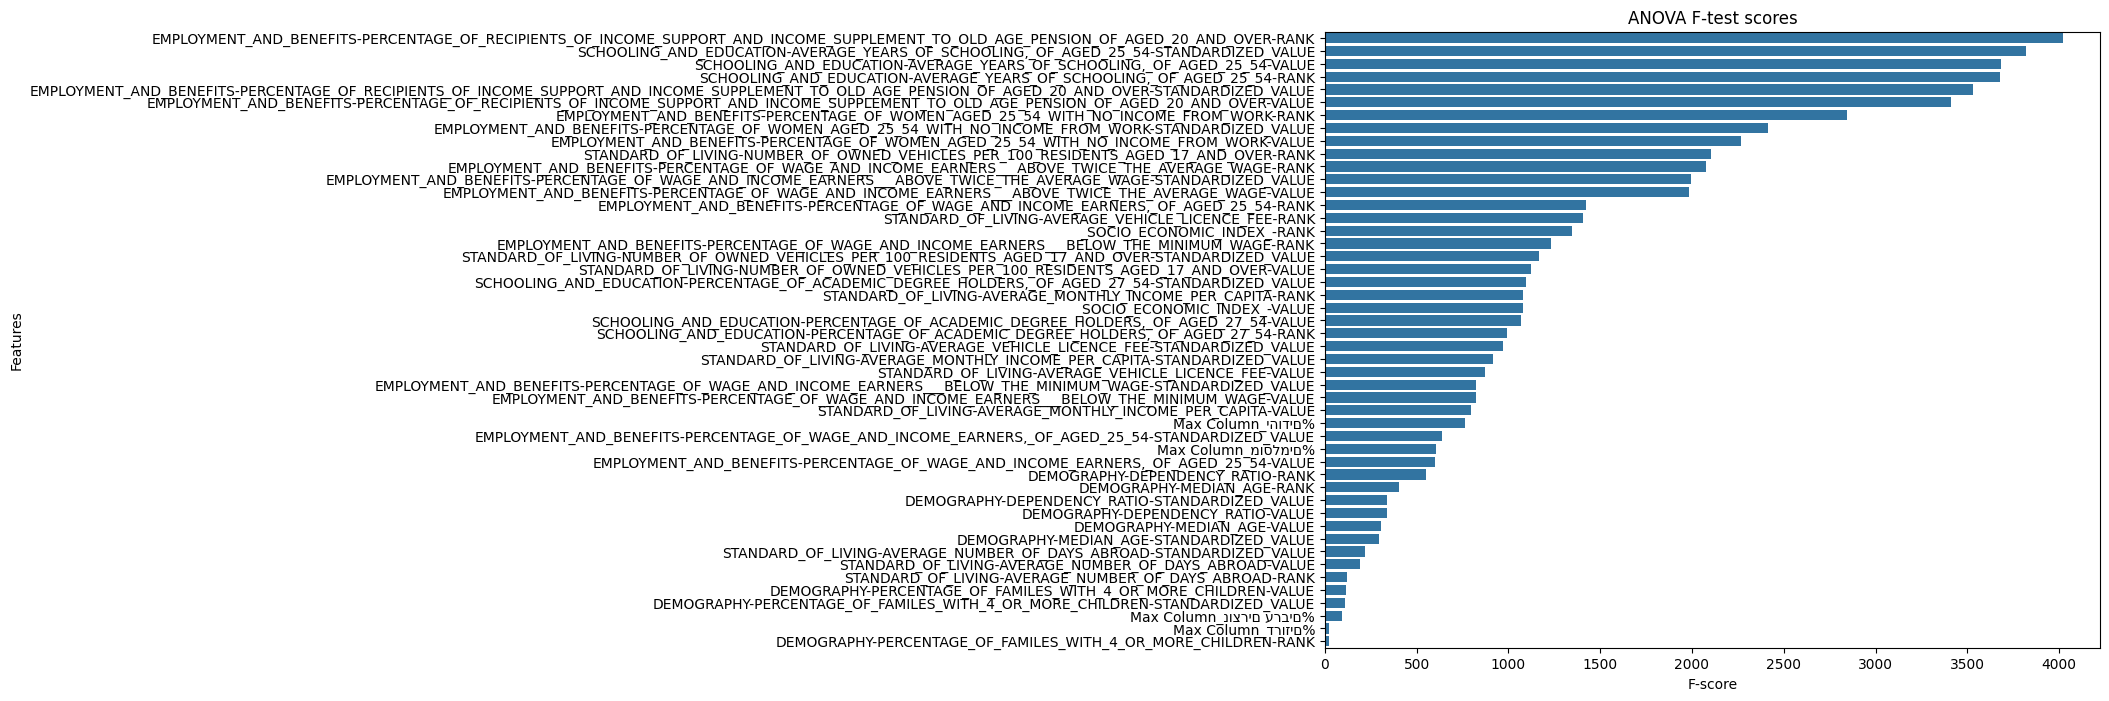

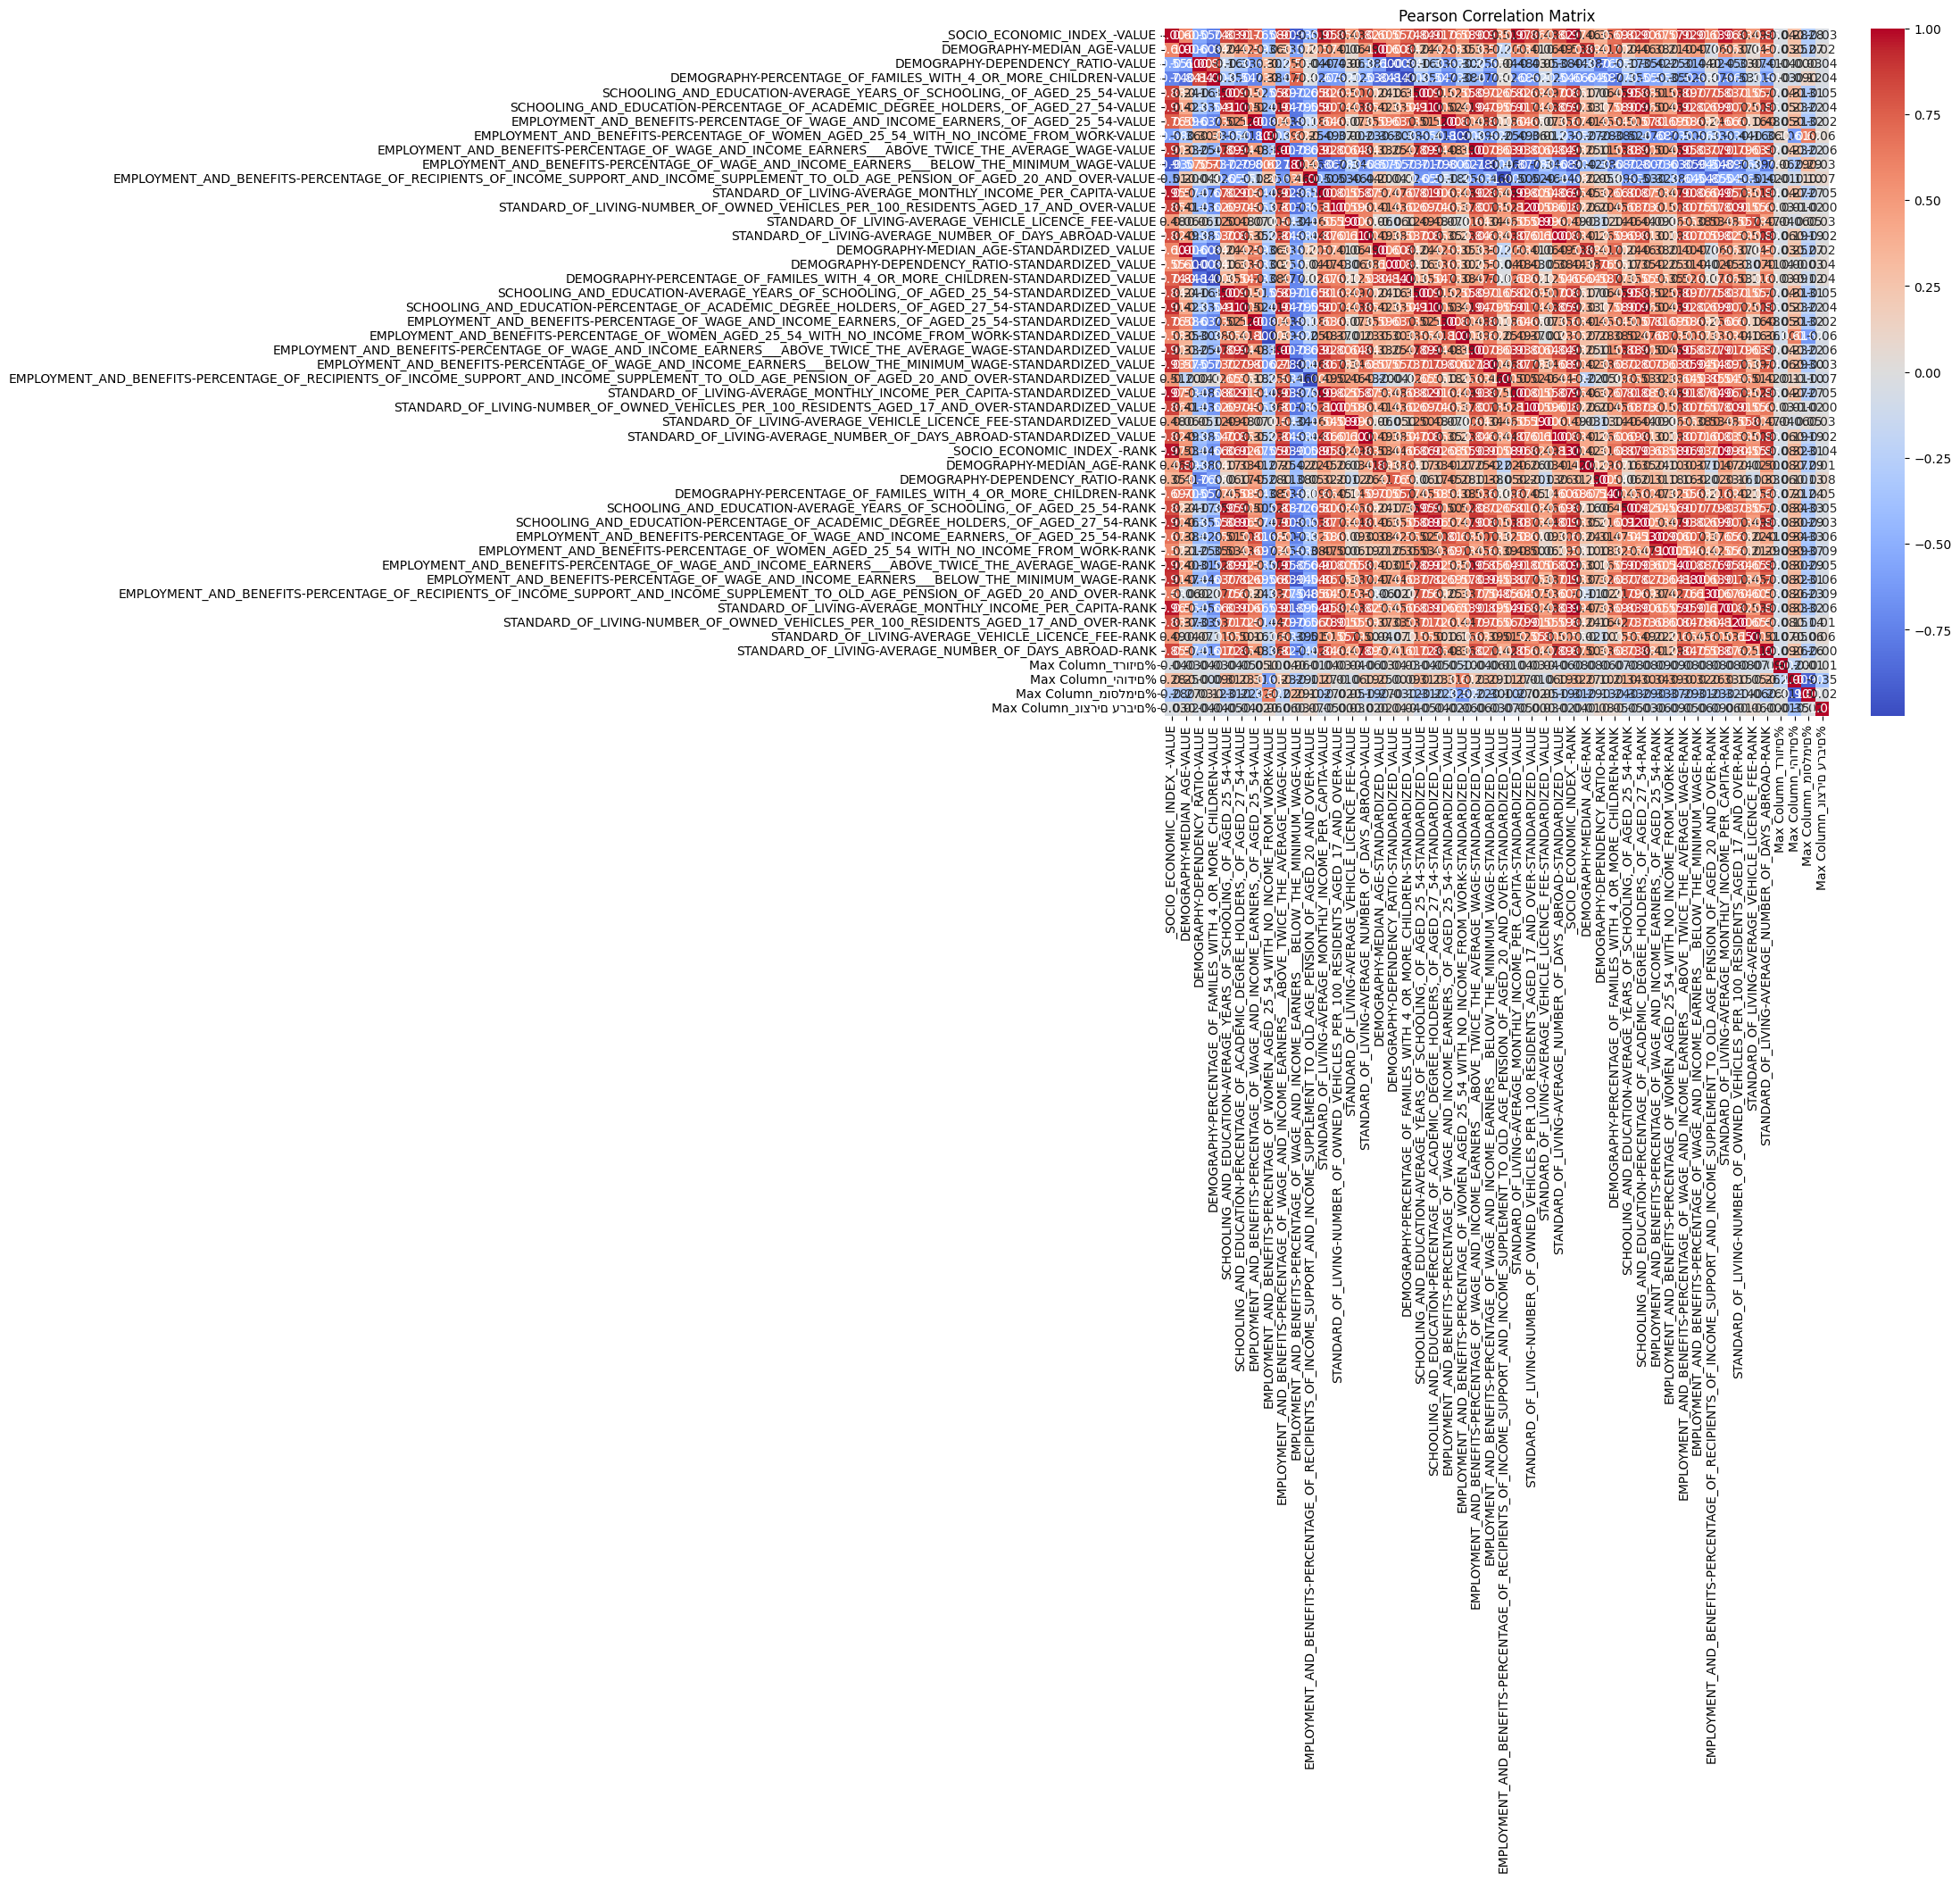

In [23]:
required_columns = value_columns + standardized_value_columns + rank_columns + religion_oneHot

# Prepare the data
X = data[required_columns]
y = data['Voting precantage']

# Compute correlation matrix
correlation_matrix = X.corrwith(y).sort_values(ascending=False)
print("Correlation with Voting Percentage:\n", correlation_matrix)

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.barplot(x=correlation_matrix.values, y=correlation_matrix.index)
plt.title('Correlation with Voting Percentage')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

# Feature importance using Random Forest
model = RandomForestRegressor()
model.fit(X, y)
feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances.values, y=feature_importances.index)
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# ANOVA F-test scores
f_scores, p_values = f_regression(X, y)
f_scores_series = pd.Series(f_scores, index=X.columns).sort_values(ascending=False)
p_values_series = pd.Series(p_values, index=X.columns).sort_values(ascending=False)

print("ANOVA F-test scores:\n", f_scores_series)
print("p-values:\n", p_values_series)

# Plot ANOVA F-test scores
plt.figure(figsize=(10, 8))
sns.barplot(x=f_scores_series.values, y=f_scores_series.index)
plt.title('ANOVA F-test scores')
plt.xlabel('F-score')
plt.ylabel('Features')
plt.show()

# Calculate Pearson correlation matrix
correlation_matrix = X.corr(method='pearson')

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Pearson Correlation Matrix')
plt.show()



Function for evaluating models

In [24]:
def get_variable_name(var):
    name = [name for name in globals() if globals()[name] is var]
    return name[0].replace('_', ' ') if name else None

def evaluate_model(model, X_train, X_val, y_train, y_val):
    train_predictions = model.predict(X_train)
    val_predictions = model.predict(X_val)

    train_rmse = mean_squared_error(y_train, train_predictions, squared=False)
    train_mae = mean_absolute_error(y_train, train_predictions)
    train_r2 = r2_score(y_train, train_predictions)
    train_adj_r2 = 1 - (1 - train_r2) * ((X_train.shape[0] - 1) / (X_train.shape[0] - X_train.shape[1] - 1))
    train_std = np.std(train_predictions - y_train)

    val_rmse = mean_squared_error(y_val, val_predictions, squared=False)
    val_mae = mean_absolute_error(y_val, val_predictions)
    val_r2 = r2_score(y_val, val_predictions)
    val_adj_r2 = 1 - (1 - val_r2) * ((X_val.shape[0] - 1) / (X_val.shape[0] - X_val.shape[1] - 1))
    val_std = np.std(val_predictions - y_val)

    model_name = get_variable_name(model)
    print(f"{model_name} Results:")
    print(f"Training Set RMSE: {train_rmse}")
    print(f"Training Set MAE: {train_mae}")
    print(f"Training Set R-squared: {train_r2}")
    print(f"Training Set Adjusted R-squared: {train_adj_r2}")
    print(f"Training Set Standard Deviation: {train_std}")
    print(f"Validation Set RMSE: {val_rmse}")
    print(f"Validation Set MAE: {val_mae}")
    print(f"Validation Set R-squared: {val_r2}")
    print(f"Validation Set Adjusted R-squared: {val_adj_r2}")
    print(f"Validation Set Standard Deviation: {val_std}")
    print("\n")


    return train_rmse, train_mae, train_r2, train_adj_r2, train_std, val_rmse, val_mae, val_r2, val_adj_r2, val_std

**Models**

In [25]:
X_value = data[value_columns + religion_oneHot]
X_standardized_value = data[standardized_value_columns + religion_oneHot]
X_rank = data[rank_columns + religion_oneHot]
y = data['Voting precantage']

X_value_train, X_value_val, y_train, y_val = train_test_split(X_value, y, test_size=0.2, random_state=42)
X_standardized_value_train, X_standardized_value_val, _, _ = train_test_split(X_standardized_value, y, test_size=0.2, random_state=42)
X_rank_train, X_rank_val, _, _ = train_test_split(X_rank, y, test_size=0.2, random_state=42)

Linear Regression

In [26]:
LR_model_value = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

LR_model_value.fit(X_value_train, y_train)

LR_model_standardized_value = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

LR_model_standardized_value.fit(X_standardized_value_train, y_train)

LR_model_rank = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

LR_model_rank.fit(X_rank_train, y_train)

train_rmse_value, train_mae_value, train_r2_value, train_adj_r2_value, train_std_value, val_rmse_value, val_mae_value, val_r2_value, val_adj_r2_value, val_std_value = evaluate_model(LR_model_value, X_value_train, X_value_val, y_train, y_val)
train_rmse_standardized_value, train_mae_standardized_value, train_r2_standardized_value, train_adj_r2_standardized_value, train_std_standardized_value, val_rmse_standardized_value, val_mae_standardized_value, val_r2_standardized_value, val_adj_r2_standardized_value, val_std_standardized_value = evaluate_model(LR_model_standardized_value, X_standardized_value_train, X_standardized_value_val, y_train, y_val)
train_rmse_rank, train_mae_rank, train_r2_rank, train_adj_r2_rank, train_std_rank, val_rmse_rank, val_mae_rank, val_r2_rank, val_adj_r2_rank, val_std_rank = evaluate_model(LR_model_rank, X_rank_train, X_rank_val, y_train, y_val)


LR model value Results:
Training Set RMSE: 0.06797142714622109
Training Set MAE: 0.04595006241699319
Training Set R-squared: 0.6476868945742928
Training Set Adjusted R-squared: 0.646618938447444
Training Set Standard Deviation: 0.06797142714622108
Validation Set RMSE: 0.06742669927503228
Validation Set MAE: 0.04595617147165268
Validation Set R-squared: 0.6443255636756005
Validation Set Adjusted R-squared: 0.6399741056651924
Validation Set Standard Deviation: 0.06742090826301882


LR model standardized value Results:
Training Set RMSE: 0.06856380702562606
Training Set MAE: 0.046751237340678355
Training Set R-squared: 0.6415192255542876
Training Set Adjusted R-squared: 0.6404899299824225
Training Set Standard Deviation: 0.06856380702562605
Validation Set RMSE: 0.06881303195028478
Validation Set MAE: 0.047515306720960576
Validation Set R-squared: 0.6295494545770086
Validation Set Adjusted R-squared: 0.6252585216184412
Validation Set Standard Deviation: 0.06880115536874239


LR model rank 

Decision Tree

In [27]:
# Define custom scoring functions for evaluation metrics
scoring = {
    'neg_root_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False, squared=False),
    'neg_mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
    'r2': make_scorer(r2_score)
}

# Step 4: Train the Decision Tree Models
tree_model_value = DecisionTreeRegressor(random_state=42)
tree_model_standardized_value = DecisionTreeRegressor(random_state=42)
tree_model_rank = DecisionTreeRegressor(random_state=42)

# Perform cross-validation
cv_results_value = cross_validate(tree_model_value, X_value_train, y_train, scoring=scoring, cv=5, return_train_score=True)
cv_results_standardized_value = cross_validate(tree_model_standardized_value, X_standardized_value_train, y_train, scoring=scoring, cv=5, return_train_score=True)
cv_results_rank = cross_validate(tree_model_rank, X_rank_train, y_train, scoring=scoring, cv=5, return_train_score=True)

# Extract mean scores from cross-validation results
train_rmse_tree_value = -np.mean(cv_results_value['train_neg_root_mean_squared_error'])
train_mae_tree_value = -np.mean(cv_results_value['train_neg_mean_absolute_error'])
train_r2_tree_value = np.mean(cv_results_value['train_r2'])
val_rmse_tree_value = -np.mean(cv_results_value['test_neg_root_mean_squared_error'])
val_mae_tree_value = -np.mean(cv_results_value['test_neg_mean_absolute_error'])
val_r2_tree_value = np.mean(cv_results_value['test_r2'])

train_rmse_tree_standardized_value = -np.mean(cv_results_standardized_value['train_neg_root_mean_squared_error'])
train_mae_tree_standardized_value = -np.mean(cv_results_standardized_value['train_neg_mean_absolute_error'])
train_r2_tree_standardized_value = np.mean(cv_results_standardized_value['train_r2'])
val_rmse_tree_standardized_value = -np.mean(cv_results_standardized_value['test_neg_root_mean_squared_error'])
val_mae_tree_standardized_value = -np.mean(cv_results_standardized_value['test_neg_mean_absolute_error'])
val_r2_tree_standardized_value = np.mean(cv_results_standardized_value['test_r2'])

train_rmse_tree_rank = -np.mean(cv_results_rank['train_neg_root_mean_squared_error'])
train_mae_tree_rank = -np.mean(cv_results_rank['train_neg_mean_absolute_error'])
train_r2_tree_rank = np.mean(cv_results_rank['train_r2'])
val_rmse_tree_rank = -np.mean(cv_results_rank['test_neg_root_mean_squared_error'])
val_mae_tree_rank = -np.mean(cv_results_rank['test_neg_mean_absolute_error'])
val_r2_tree_rank = np.mean(cv_results_rank['test_r2'])

# Display Results
print("Decision Tree (VALUE) Results:")
print("Training Set RMSE:", train_rmse_tree_value)
print("Training Set MAE:", train_mae_tree_value)
print("Training Set R-squared:", train_r2_tree_value)
print("Validation Set RMSE:", val_rmse_tree_value)
print("Validation Set MAE:", val_mae_tree_value)
print("Validation Set R-squared:", val_r2_tree_value)

print("\nDecision Tree (STANDARDIZED_VALUE) Results:")
print("Training Set RMSE:", train_rmse_tree_standardized_value)
print("Training Set MAE:", train_mae_tree_standardized_value)
print("Training Set R-squared:", train_r2_tree_standardized_value)
print("Validation Set RMSE:", val_rmse_tree_standardized_value)
print("Validation Set MAE:", val_mae_tree_standardized_value)
print("Validation Set R-squared:", val_r2_tree_standardized_value)

print("\nDecision Tree (RANK) Results:")
print("Training Set RMSE:", train_rmse_tree_rank)
print("Training Set MAE:", train_mae_tree_rank)
print("Training Set R-squared:", train_r2_tree_rank)
print("Validation Set RMSE:", val_rmse_tree_rank)
print("Validation Set MAE:", val_mae_tree_rank)
print("Validation Set R-squared:", val_r2_tree_rank)


Decision Tree (VALUE) Results:
Training Set RMSE: 0.025056887847566173
Training Set MAE: 0.013715677537504717
Training Set R-squared: 0.9521126819910837
Validation Set RMSE: 0.05957344307650779
Validation Set MAE: 0.0366069434589721
Validation Set R-squared: 0.7281114433643016

Decision Tree (STANDARDIZED_VALUE) Results:
Training Set RMSE: 0.04368274008840135
Training Set MAE: 0.021509814790143106
Training Set R-squared: 0.8544533026531098
Validation Set RMSE: 0.06121029741759115
Validation Set MAE: 0.03879809242789998
Validation Set R-squared: 0.7130187292114825

Decision Tree (RANK) Results:
Training Set RMSE: 0.025056887847566173
Training Set MAE: 0.013715677537504717
Training Set R-squared: 0.9521126819910837
Validation Set RMSE: 0.05493745494029575
Validation Set MAE: 0.034887469492516525
Validation Set R-squared: 0.7688315240928663


In [28]:
forest_model_value = RandomForestRegressor(random_state=42)
forest_model_value.fit(X_value_train, y_train)

forest_model_standardized_value = RandomForestRegressor(random_state=42)
forest_model_standardized_value.fit(X_standardized_value_train, y_train)

forest_model_rank = RandomForestRegressor(random_state=42)
forest_model_rank.fit(X_rank_train, y_train)

# Step 5: Evaluate the Random Forest Models
train_rmse_forest_value, train_mae_forest_value, train_r2_forest_value, _, train_std_forest_value, val_rmse_forest_value, val_mae_forest_value, val_r2_forest_value, _, val_std_forest_value = evaluate_model(forest_model_value, X_value_train, X_value_val, y_train, y_val)
train_rmse_forest_standardized_value, train_mae_forest_standardized_value, train_r2_forest_standardized_value, _, train_std_forest_standardized_value, val_rmse_forest_standardized_value, val_mae_forest_standardized_value, val_r2_forest_standardized_value, _, val_std_forest_standardized_value = evaluate_model(forest_model_standardized_value, X_standardized_value_train, X_standardized_value_val, y_train, y_val)
train_rmse_forest_rank, train_mae_forest_rank, train_r2_forest_rank, _, train_std_forest_rank,val_rmse_forest_rank, val_mae_forest_rank, val_r2_forest_rank, _, val_std_forest_rank = evaluate_model(forest_model_rank, X_rank_train, X_rank_val, y_train, y_val)

forest model value Results:
Training Set RMSE: 0.029764521251453124
Training Set MAE: 0.01904848427265413
Training Set R-squared: 0.9324424604202631
Training Set Adjusted R-squared: 0.9322376752811414
Training Set Standard Deviation: 0.029738899897268075
Validation Set RMSE: 0.04843011352692233
Validation Set MAE: 0.031351856112383766
Validation Set R-squared: 0.8165068629481209
Validation Set Adjusted R-squared: 0.8142619372533458
Validation Set Standard Deviation: 0.04834098360158384


forest model standardized value Results:
Training Set RMSE: 0.045266743925114955
Training Set MAE: 0.025090448133623242
Training Set R-squared: 0.8437447801695563
Training Set Adjusted R-squared: 0.843296129035891
Training Set Standard Deviation: 0.04525154108894806
Validation Set RMSE: 0.052975637592146387
Validation Set MAE: 0.034755273656395524
Validation Set R-squared: 0.7804460594789078
Validation Set Adjusted R-squared: 0.7779029636427561
Validation Set Standard Deviation: 0.0528917946849631


fo

compare models

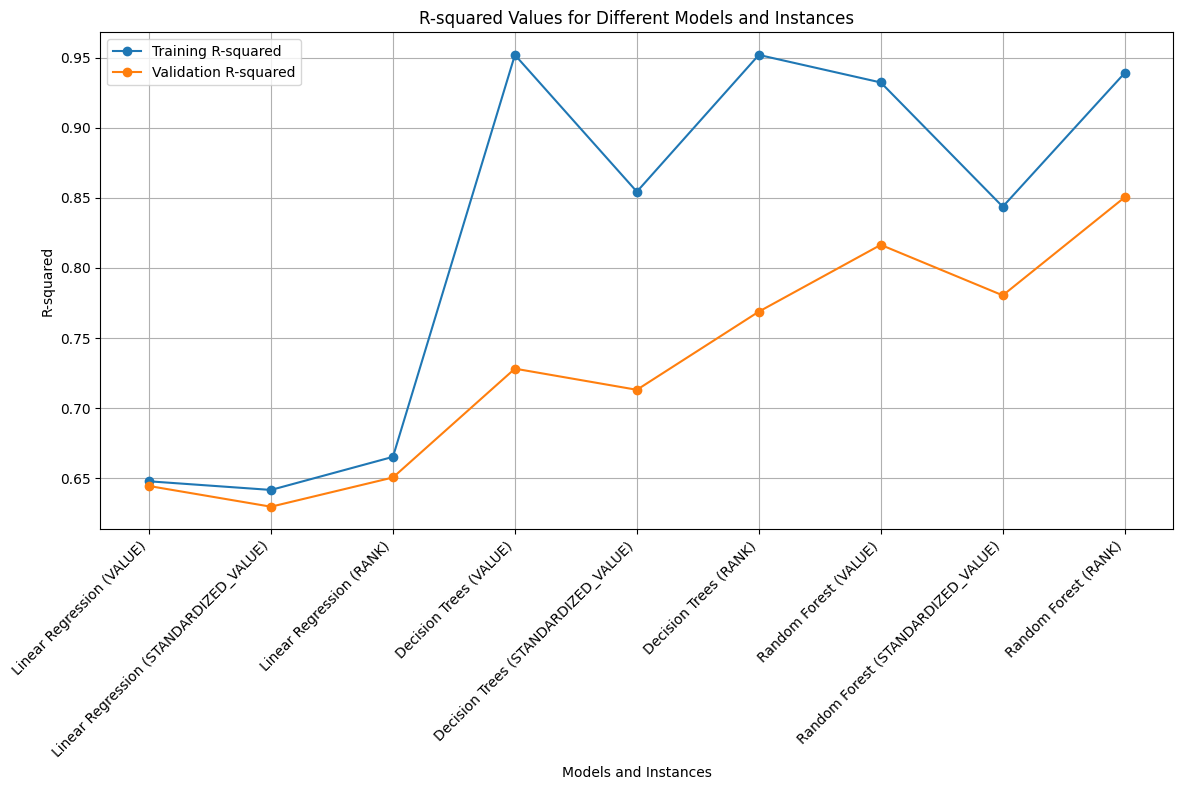

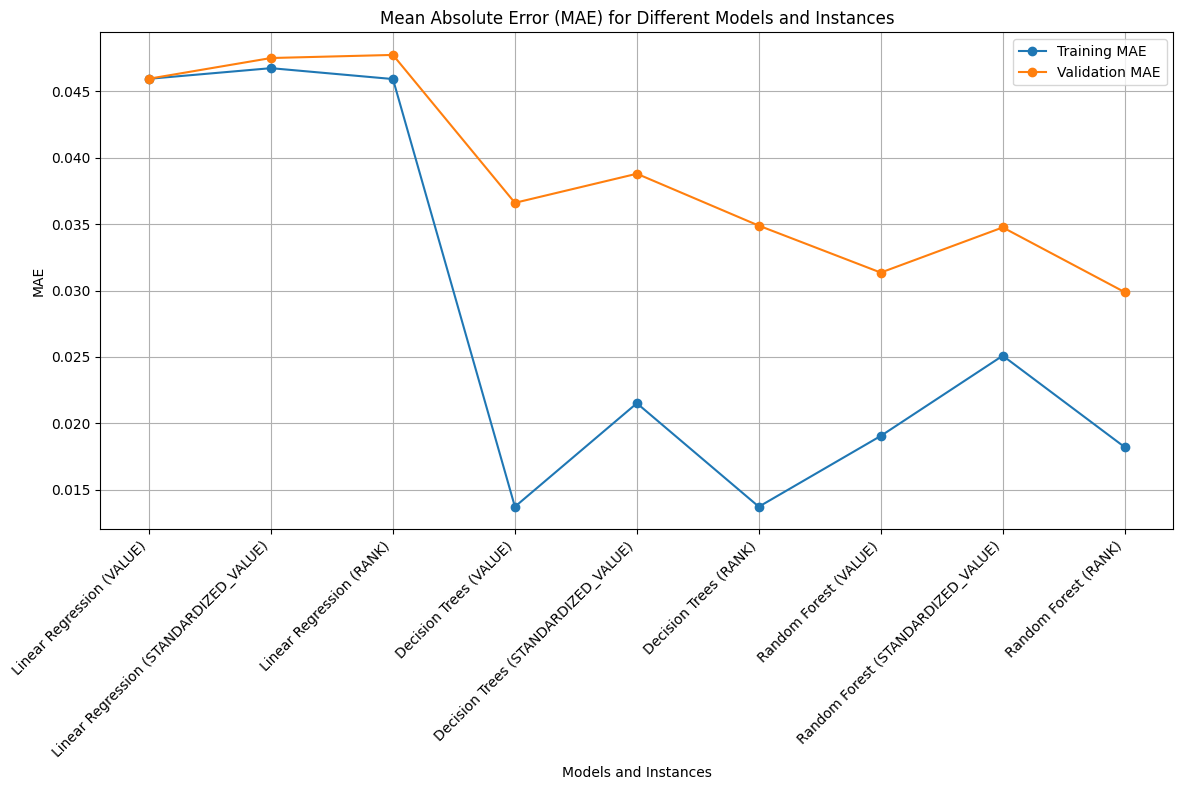

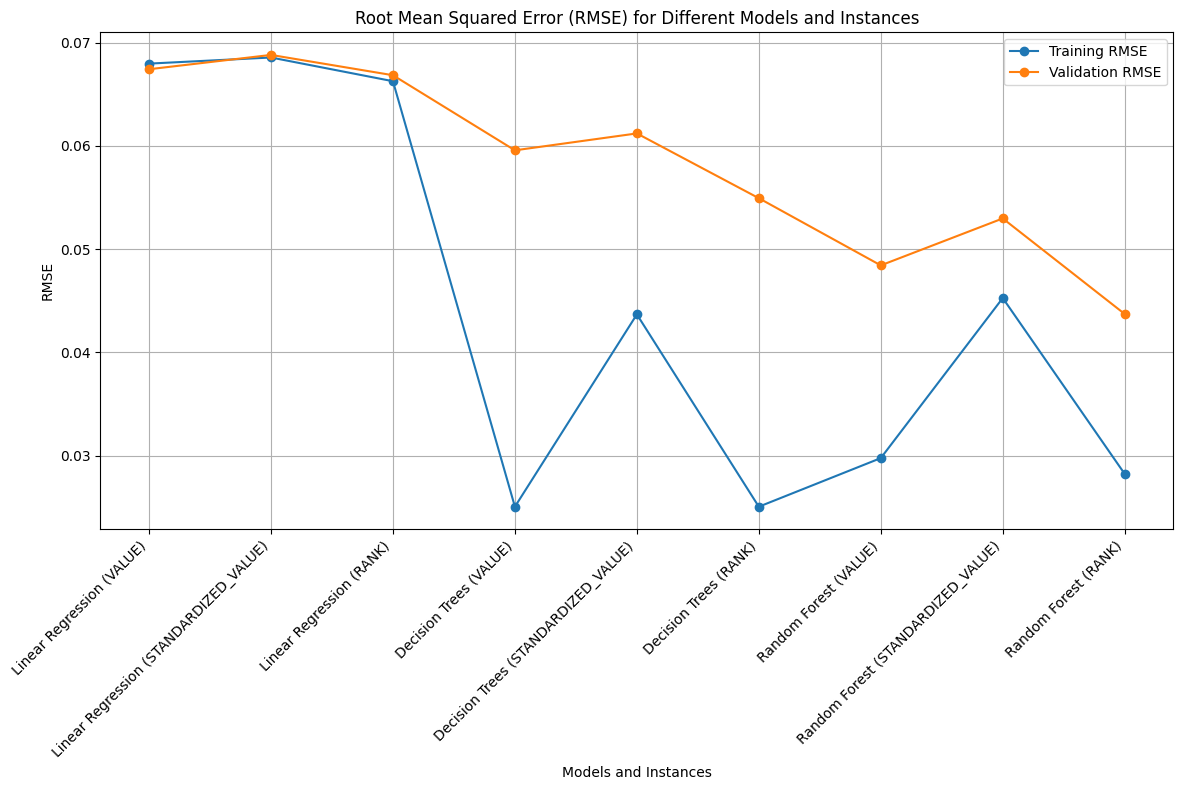

In [29]:
# Define model names and their corresponding R-squared values
models = ['Linear Regression (VALUE)', 'Linear Regression (STANDARDIZED_VALUE)', 'Linear Regression (RANK)', 'Decision Trees (VALUE)', 'Decision Trees (STANDARDIZED_VALUE)', 'Decision Trees (RANK)',
          'Random Forest (VALUE)', 'Random Forest (STANDARDIZED_VALUE)', 'Random Forest (RANK)']
train_r2_values = [train_r2_value, train_r2_standardized_value, train_r2_rank, train_r2_tree_value, train_r2_tree_standardized_value, train_r2_tree_rank,
                   train_r2_forest_value, train_r2_forest_standardized_value, train_r2_forest_rank]
val_r2_values = [val_r2_value, val_r2_standardized_value, val_r2_rank, val_r2_tree_value, val_r2_tree_standardized_value, val_r2_tree_rank,
                 val_r2_forest_value, val_r2_forest_standardized_value, val_r2_forest_rank]

# Plotting R-squared values for both training and validation sets
plt.figure(figsize=(12, 8))
plt.plot(models, train_r2_values, marker='o', label='Training R-squared')
plt.plot(models, val_r2_values, marker='o', label='Validation R-squared')
plt.title('R-squared Values for Different Models and Instances')
plt.xlabel('Models and Instances')
plt.ylabel('R-squared')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('R-squared Values for Different Models and Instances.png')
plt.show()

# Define MAE values for training and validation sets
train_mae_values = [train_mae_value, train_mae_standardized_value, train_mae_rank, train_mae_tree_value, train_mae_tree_standardized_value, train_mae_tree_rank,
                    train_mae_forest_value, train_mae_forest_standardized_value, train_mae_forest_rank]
val_mae_values = [val_mae_value, val_mae_standardized_value, val_mae_rank, val_mae_tree_value, val_mae_tree_standardized_value, val_mae_tree_rank,
                  val_mae_forest_value, val_mae_forest_standardized_value, val_mae_forest_rank]

# Define RMSE values for training and validation sets
train_rmse_values = [train_rmse_value, train_rmse_standardized_value, train_rmse_rank, train_rmse_tree_value, train_rmse_tree_standardized_value, train_rmse_tree_rank,
                     train_rmse_forest_value, train_rmse_forest_standardized_value, train_rmse_forest_rank]
val_rmse_values = [val_rmse_value, val_rmse_standardized_value, val_rmse_rank, val_rmse_tree_value, val_rmse_tree_standardized_value, val_rmse_tree_rank,
                   val_rmse_forest_value, val_rmse_forest_standardized_value, val_rmse_forest_rank]

# Plotting MAE values for both training and validation sets
plt.figure(figsize=(12, 8))
plt.plot(models, train_mae_values, marker='o', label='Training MAE')
plt.plot(models, val_mae_values, marker='o', label='Validation MAE')
plt.title('Mean Absolute Error (MAE) for Different Models and Instances')
plt.xlabel('Models and Instances')
plt.ylabel('MAE')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Mean Absolute Error (MAE) for Different Models and Instances.png')
plt.show()

# Plotting RMSE values for both training and validation sets
plt.figure(figsize=(12, 8))
plt.plot(models, train_rmse_values, marker='o', label='Training RMSE')
plt.plot(models, val_rmse_values, marker='o', label='Validation RMSE')
plt.title('Root Mean Squared Error (RMSE) for Different Models and Instances')
plt.xlabel('Models and Instances')
plt.ylabel('RMSE')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Root Mean Squared Error (RMSE) for  Different Models and Instances.png')
plt.show()


best model

In [30]:
# Create a dictionary to store model names and their corresponding evaluation metrics
model_metrics = {
    'Model': models,
    'Train_RMSE': train_rmse_values,
    'Val_RMSE': val_rmse_values,
    'Train_MAE': train_mae_values,
    'Val_MAE': val_mae_values,
    'Train_R2': train_r2_values,
    'Val_R2': val_r2_values
}

# Convert the dictionary to a DataFrame for easier manipulation and visualization
metrics_df = pd.DataFrame(model_metrics)

# Sort the DataFrame by the desired metric (e.g., Val_RMSE)
sorted_metrics_df = metrics_df.sort_values(by='Val_RMSE', ascending=True)

# Display the sorted DataFrame
print(sorted_metrics_df)

# Based on the sorted DataFrame, choose the best model considering multiple metrics
best_model_index = sorted_metrics_df['Val_RMSE'].idxmin()
best_model_name = sorted_metrics_df.loc[best_model_index, 'Model']

print(f"\nThe best model based on minimal validation RMSE is: {best_model_name}")

                                    Model  Train_RMSE  Val_RMSE  Train_MAE  \
8                    Random Forest (RANK)    0.028231  0.043720   0.018205   
6                   Random Forest (VALUE)    0.029765  0.048430   0.019048   
7      Random Forest (STANDARDIZED_VALUE)    0.045267  0.052976   0.025090   
5                   Decision Trees (RANK)    0.025057  0.054937   0.013716   
3                  Decision Trees (VALUE)    0.025057  0.059573   0.013716   
4     Decision Trees (STANDARDIZED_VALUE)    0.043683  0.061210   0.021510   
2                Linear Regression (RANK)    0.066266  0.066847   0.045931   
0               Linear Regression (VALUE)    0.067971  0.067427   0.045950   
1  Linear Regression (STANDARDIZED_VALUE)    0.068564  0.068813   0.046751   

    Val_MAE  Train_R2    Val_R2  
8  0.029879  0.939222  0.850460  
6  0.031352  0.932442  0.816507  
7  0.034755  0.843745  0.780446  
5  0.034887  0.952113  0.768832  
3  0.036607  0.952113  0.728111  
4  0.038798  0.

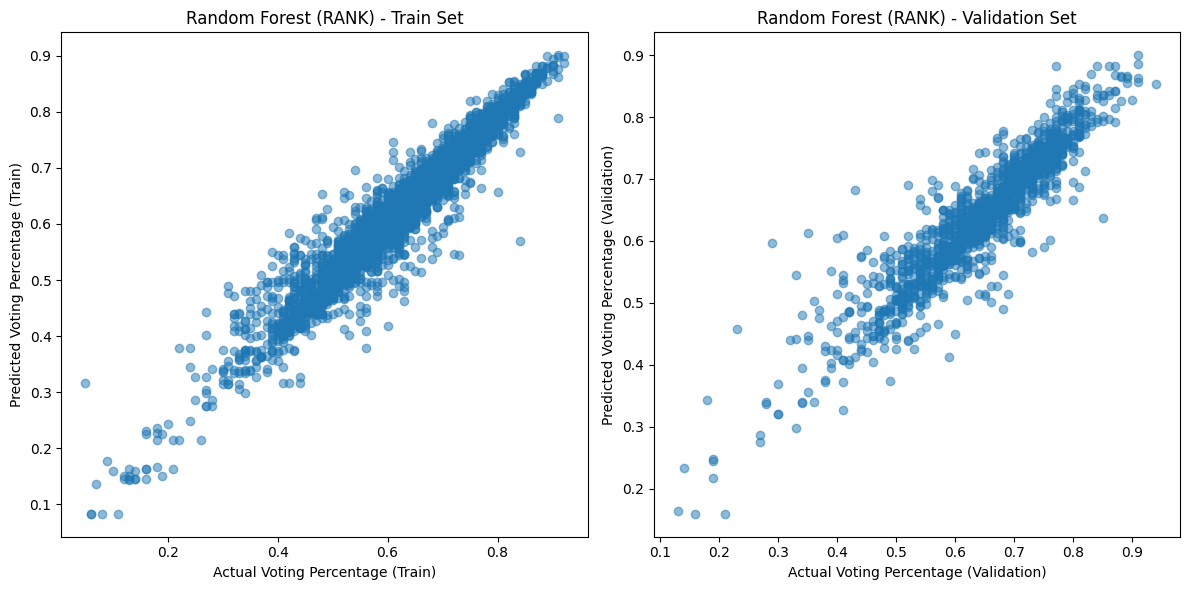

In [31]:
# Predictions on training and validation sets
train_predictions_forest_rank = forest_model_rank.predict(X_rank_train)
val_predictions_forest_rank = forest_model_rank.predict(X_rank_val)

# Scatter plots for predicted vs actual values
plt.figure(figsize=(12, 6))

# Training set plot
plt.subplot(1, 2, 1)
plt.scatter(y_train, train_predictions_forest_rank, alpha=0.5)
plt.xlabel('Actual Voting Percentage (Train)')
plt.ylabel('Predicted Voting Percentage (Train)')
plt.title('Random Forest (RANK) - Train Set')

# Validation set plot
plt.subplot(1, 2, 2)
plt.scatter(y_val, val_predictions_forest_rank, alpha=0.5)
plt.xlabel('Actual Voting Percentage (Validation)')
plt.ylabel('Predicted Voting Percentage (Validation)')
plt.title('Random Forest (RANK) - Validation Set')

plt.tight_layout()
plt.show()

**Test the Model**

In [32]:
all_columns = test.columns
all_columns = [col for col in all_columns if not col.startswith('_SOCIO_ECONOMIC_INDEX')]
value_columns = [col for col in all_columns if col.endswith('-VALUE')]
standardized_value_columns = [col for col in all_columns if col.endswith('-STANDARDIZED_VALUE')]
rank_columns = [col for col in all_columns if col.endswith('-RANK')]
religion_oneHot = [col for col in all_columns if col.startswith('Max Column_')]

X_rank = test[rank_columns + religion_oneHot]
X_rank_test = test[rank_columns + religion_oneHot]

predictions = forest_model_rank.predict(X_rank_test)


predictions_data = test.copy()
predictions_data['Predicted Voting Percentage'] = predictions

# Save the predictions to an Excel file
predictions_data.to_excel('predictions.xlsx')

In [33]:
# Extract actual and predicted values
y_true = predictions_data['Voting precantage']
y_pred = predictions_data['Predicted Voting Percentage']

# Calculate evaluation metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
std_residuals = np.std(y_pred - y_true)
# Print the evaluation metrics
print("Regression - Random Forest")
print("Train RMSE\t", round(train_rmse_forest_rank, 3))
print("Test RMSE\t", round(rmse, 3))
print("Train MAE\t", round(train_mae_forest_rank, 3))
print("Test MAE\t", round(mae, 3))
print("Train R2\t", round(train_r2_forest_rank, 3))
print("Test R2\t\t", round(r2, 3))
print("Train STD\t", round(train_std_forest_rank, 3))
print("Test STD\t", round(std_residuals, 3))

Mean Absolute Error: 0.027
Mean Squared Error: 0.002
R-squared: 0.875
Root Mean Squared Error: 0.039
Standard Deviation of Residuals: 0.038


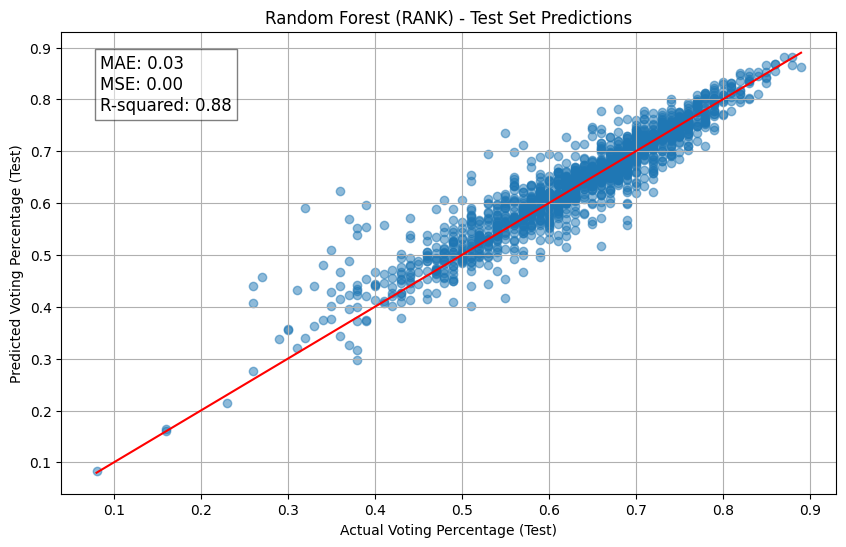

In [ ]:
# Scatter plot for predicted vs actual values on test data
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red')  # Diagonal line
plt.xlabel('Actual Voting Percentage (Test)')
plt.ylabel('Predicted Voting Percentage (Test)')
# Display metrics as text on the plot
plt.text(0.05, 0.95, f'MAE: {mae:.2f}\nMSE: {mse:.2f}\nR-squared: {np.ceil(r2 * 100) / 100:.2f}',
         transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
plt.title('Random Forest (RANK) - Test Set Predictions')
plt.grid(True)
plt.show()

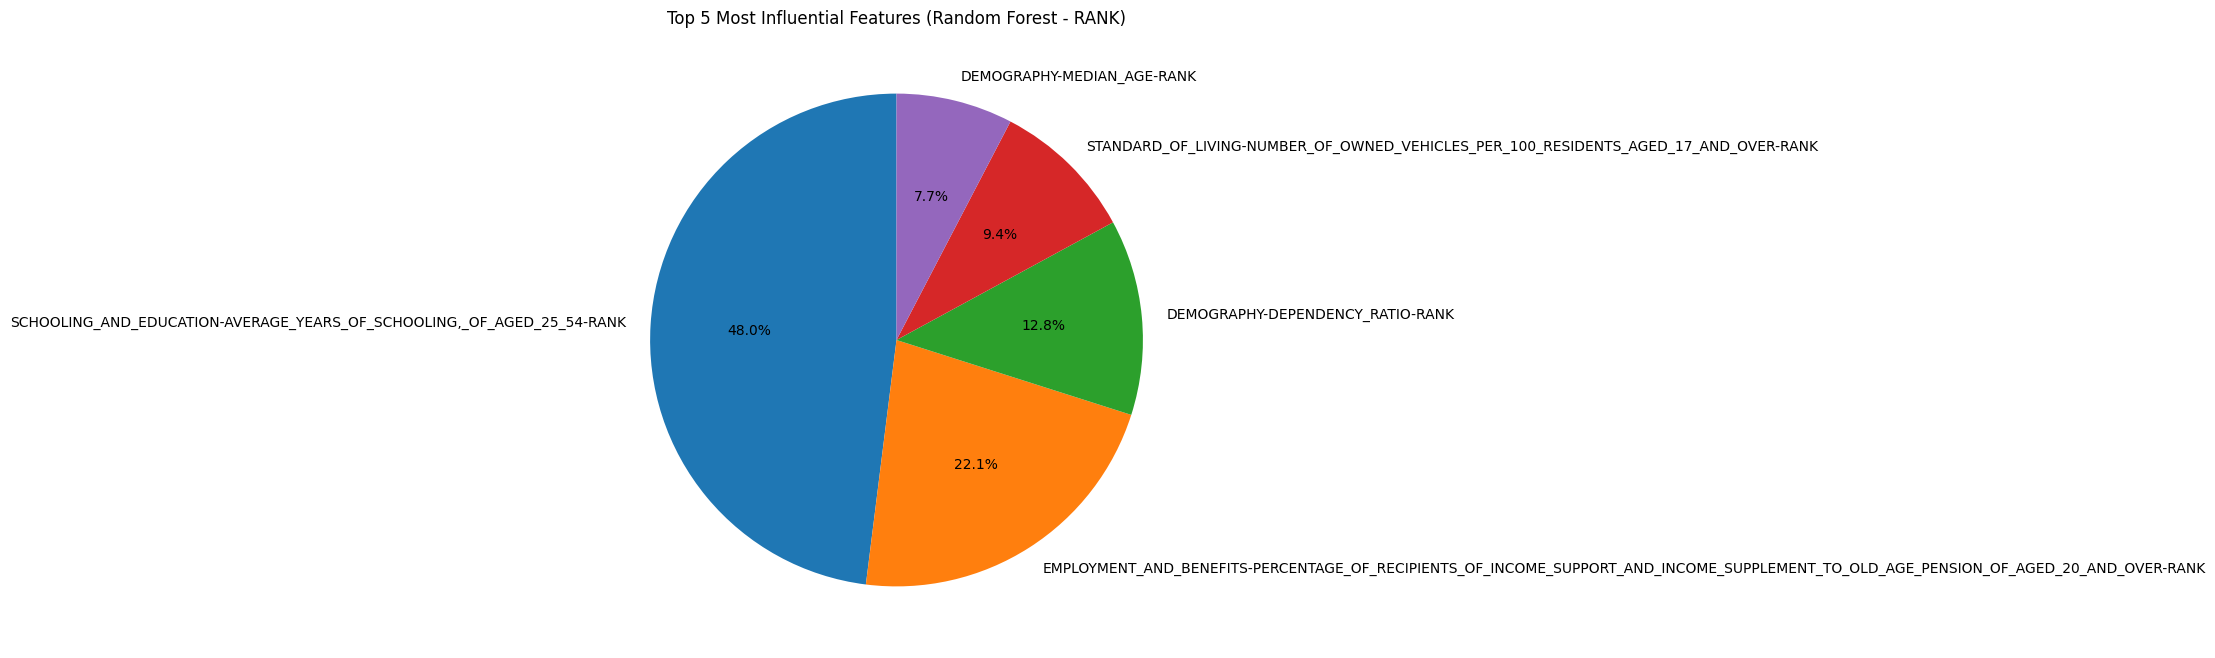

In [35]:
# Get feature importances
importances = forest_model_rank.feature_importances_

# Get feature names
feature_names = X_rank_train.columns

# Create a DataFrame to store feature importances
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)

# Select the top 5 features
top_5_features = feature_importances_df.head(5)

# Plot the top 5 features as a pie chart
plt.figure(figsize=(8, 8))
plt.pie(top_5_features['Importance'], labels=top_5_features['Feature'], autopct='%1.1f%%', startangle=90)
plt.title('Top 5 Most Influential Features (Random Forest - RANK)')
plt.show()


<ipython-input-36-9d88c899d1e5>:34: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle((0.5 - 0.1*(5-i), y), 0.2*(5-i), 0.2, color=color, edgecolor='black')


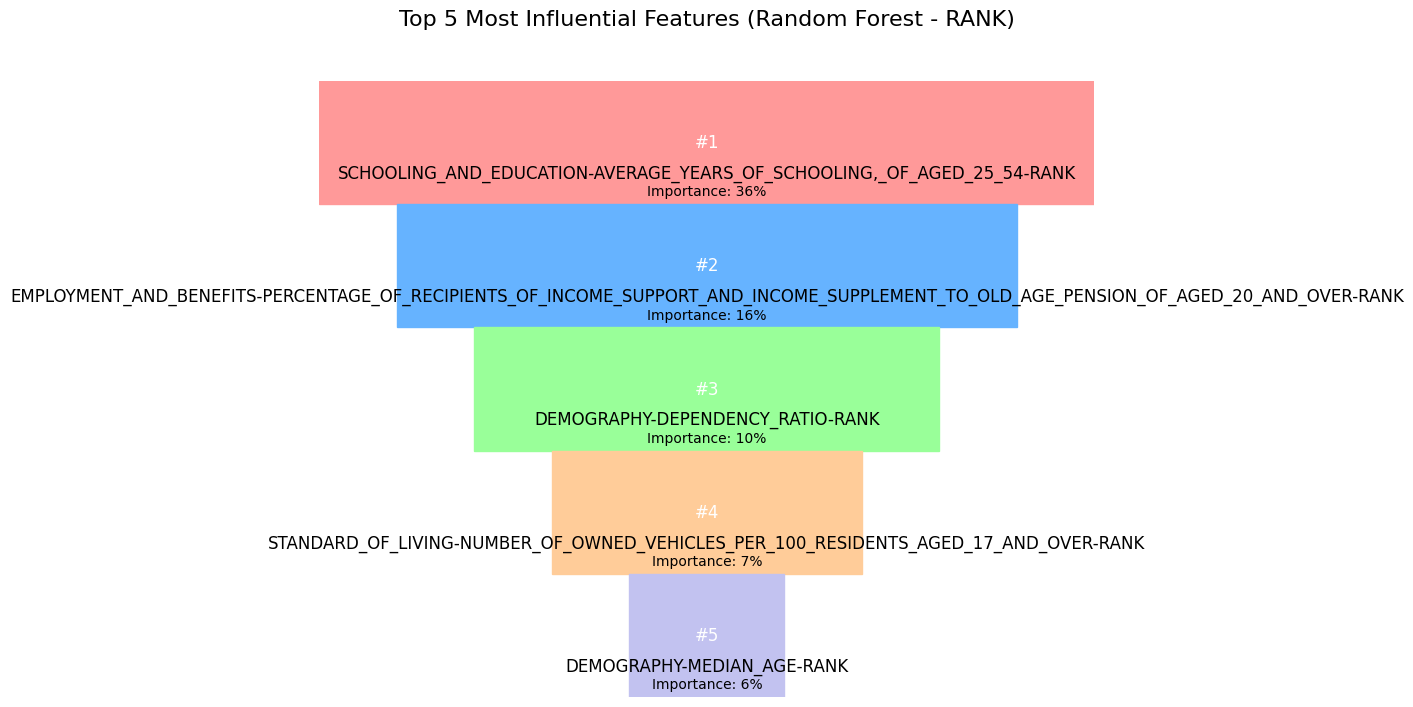

<ipython-input-36-9d88c899d1e5>:66: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle((0.5 - 0.1*(3-i), y), 0.2*(3-i), 0.2, color=color, edgecolor='black')


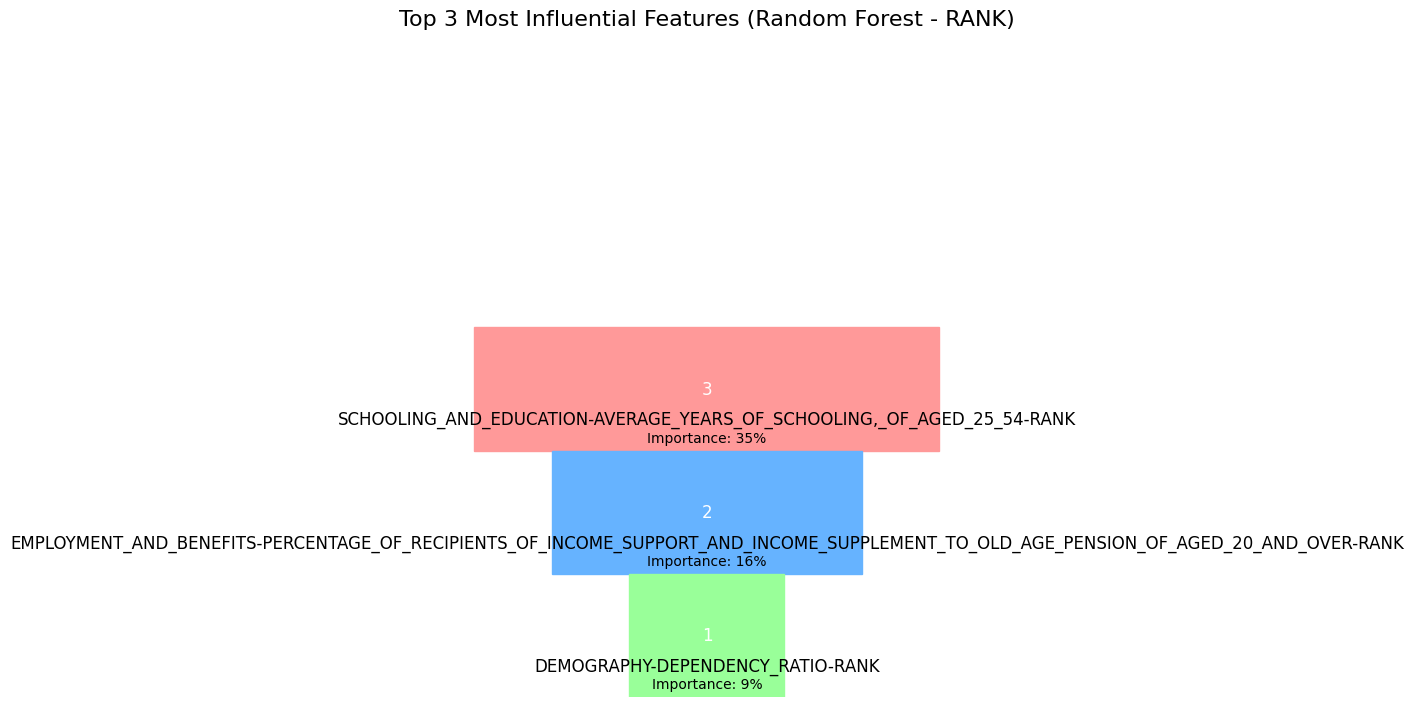

In [36]:

# Get feature importances from the trained Random Forest model
importances = forest_model_rank.feature_importances_

# Get feature names from the DataFrame
feature_names = X_rank.columns

# Create a DataFrame to store feature importances
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)

# Select the top 5 features
top_5_features = feature_importances_df.head(5)

# Extract feature names and importance values
features = top_5_features['Feature'].tolist()
importances = top_5_features['Importance'].tolist()

# Create a pyramid plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.axis('off')  # Turn off the axis

# Define the pyramid layers
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0']
y_positions = [0.8, 0.6, 0.4, 0.2, 0.0]

# Plot each layer
for i, (feature, importance, color, y) in enumerate(zip(features, importances, colors, y_positions)):
    rect = Rectangle((0.5 - 0.1*(5-i), y), 0.2*(5-i), 0.2, color=color, edgecolor='black')
    ax.add_patch(rect)
    ax.text(0.5, y + 0.1, f'#{i+1}', fontsize=12, ha='center', va='center', color='white')
    ax.text(0.5, y + 0.05, feature, fontsize=12, ha='center', va='center', color='black')
    ax.text(0.5, y + 0.02, f'Importance: {int(round(importance * 100))}%', fontsize=10, ha='center', va='center', color='black')

# Set plot title with more padding
plt.title('Top 5 Most Influential Features (Random Forest - RANK)', fontsize=16, pad=40)

# Show the plot
plt.show()

# Select the top 3 features
top_3_features = feature_importances_df.head(3)

# Extract feature names and importance values
features = top_3_features['Feature'].tolist()
importances = top_3_features['Importance'].tolist()

# Convert importances to percentages and then to integers
importances = [int(imp * 100) for imp in importances]

# Create a pyramid plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.axis('off')  # Turn off the axis

# Define the pyramid layers
colors = ['#ff9999','#66b3ff','#99ff99']
y_positions = [0.4, 0.2, 0.0]

# Plot each layer
for i, (feature, importance, color, y) in enumerate(zip(features, importances, colors, y_positions)):
    rect = Rectangle((0.5 - 0.1*(3-i), y), 0.2*(3-i), 0.2, color=color, edgecolor='black')
    ax.add_patch(rect)
    ax.text(0.5, y + 0.1, f'{3-i}', fontsize=12, ha='center', va='center', color='white')
    ax.text(0.5, y + 0.05, feature, fontsize=12, ha='center', va='center', color='black')
    ax.text(0.5, y + 0.02, f'Importance: {importance}%', fontsize=10, ha='center', va='center', color='black')

# Set plot title with more padding
plt.title('Top 3 Most Influential Features (Random Forest - RANK)', fontsize=16, pad=40)

# Show the plot
plt.show()

